In [854]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
from IPython.display import HTML
from IPython.display import display, Image
import pandas as pd
import numpy as np
import datetime as dt
from pandas.io.json import json_normalize
import json

In [855]:
# Opens and normalizes the JSON file.
# Then, it renames our columns and changes the type of the date column to datetime.
def normalizeDataFrame(file_name):
    # 1- Open and normalize the JSON file.
    with open(file_name) as content:
        data = json.load(content)
    df = json_normalize(data)
    # 2- Rename our columns and change the type of the date column to datetime.
    df.columns= ['id', 'n', 'verc', 'downloads', 'rDate']
    df['rDate'] = pd.to_datetime(df['rDate'])
    return df

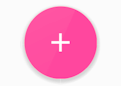

,rDate
n,
tatbigy.com.ketegram,2015-06-14
dream_chaos.java_conf.gr.jp.pokedatabase,2015-06-30
be.belgacom.imok,2015-07-01
fr.valquev.leveldown,2015-07-04
icamerasoftware.app.foscam,2015-07-09


In [856]:
# FAB using the design support library
display(HTML('<h1>Floating Action Button (FAB)</h1>'))
display(Image(filename='../images/fab.png'))
display(HTML('<h2>When did each app start getting the FAB using the design support library?</h2>'))
df = normalizeDataFrame('../data/fab/fab_using_support_lib.json')
# Get the release date of the first app version that added this design
# Group by package name, aggregate by the first release date, and sort the resulted data frame.
rdf = df.groupby('n').agg({'rDate' : np.min}).sort('rDate', ascending=True)
rdf.head()

In [857]:
display(HTML('<h2>Which month has seen the peak of adding the FAB using the design support library?</h2>'))
tdf = rdf
tdf.reset_index(inplace=True)
tdf.set_index('rDate', inplace=True)
# Group apps by month
tdf = tdf.groupby(pd.TimeGrouper("M")).count().sort(ascending=True)
tdf.to_csv('../out/fab/fab_using_support_lib_monthly.csv')
answer = tdf.sort(columns=['n'], ascending=False)[:1]
print(answer.index[0].strftime('%B,%Y') + ' has ' + str(answer['n'].values[0]) + ' apps.')
#display(tdf)
display(HTML('<h2>What is the adoption rate over time of adding the FAB using the design support library?</h2>'))
# Plot
layout = Layout(title='The adoption rate of the Floating Action Button (FAB) using the Design Support Library',
                showlegend=False,
                yaxis= YAxis(title='Apps'))
formatted_ticks = tdf.index.map(lambda t: t.strftime('%B %Y'))
data = Data([Bar(x=formatted_ticks, y=tdf['n'].tolist())])
fig = Figure(data=data, layout=layout)
iplot(fig)

November,2015 has 949 apps.


In [859]:
display(HTML('<h2>What is the adoption rate over time by download count ' +
             'of adding the FAB using the design support library?</h2>'))
df = normalizeDataFrame('../data/fab/fab_using_support_lib.json')
first_release_df = df.groupby(['n'], as_index=False).agg({'rDate' : np.min})

download_df = df[['n', 'rDate','downloads']]
# merge the first release data frame with the download data frame.
merged_df = pd.merge(first_release_df, download_df, on=['n', 'rDate'])

# Drop apps that were released twice in the same day
merged_unique_df = merged_df.drop_duplicates()
# Group them by month and download count
result = merged_unique_df.set_index('rDate').groupby([pd.TimeGrouper("M"), 'downloads']).count().sort(ascending=True)
display(result.head())
result.to_csv('../out/fab/fab_using_support_lib_by_month_nd_downloads.csv')


n
rDate      downloads   
2015-06-30 5000       1
           10000      1
2015-07-31 10         1
           100        2
           500        2

In [860]:
# Get the Y array for the less 100K trace

'''
It groups a dataframe by download count into three main groups:
1- apps with download counts less than 100K
2- apps with download counts greater or equal to 100K and less than 1M
3- apps with download counts equal or greater to 1M

The expected data frame argument should have multiindex values (rDate and downloads) 
and look like the following data frame:
-------------------------------------
   rDate     |   downloads     |  n  |
--------------------------------------
             |   500           |  2  |
  2015-06-30 -------------------------
             |   10000         |  4  |
--------------------------------------
             |   10            |  2  |
  2015-06-30 -------------------------
             |   100           |  4  |
             -------------------------
             |   500           |  4  |
             -------------------------
             |   10000         |  4  |
--------------------------------------
It returns a dict where each key contains belongs to a group and has a value of 
dict with keys of date and values of the total apps.
'''
def group_download_counts(my_df):
    less_100K_dict = {}
    between_100K_1M_dict = {}
    more_than_1M_dict = {}
    
    for row in my_df.itertuples():
        # e.g., row = ((Timestamp('2015-06-30 00:00:00'), 5000), 1)
        month_date = row[0][0]
        download_count = row[0][1]
        apps_count = row[1]
        # 1) <100K
        if download_count < 100000: # If the download count is less than 100K
            #If the date key exists in the resulting dict, add the apps count value to the previous value
            if month_date in less_100K_dict:
                less_100K_dict[month_date] = less_100K_dict[month_date] + apps_count
            else: # initalize with the new value
                less_100K_dict[month_date] = apps_count
        # 2) >= 100K to < 1M
        elif download_count >= 100000 and download_count < 1000000:
            if month_date in between_100K_1M_dict:
                between_100K_1M_dict[month_date] = between_100K_1M_dict[month_date] + apps_count
            else:
                between_100K_1M_dict[month_date] = apps_count
        # 3) >= 1M
        elif download_count >= 1000000:
            if month_date in more_than_1M_dict:
                more_than_1M_dict[month_date] = more_than_1M_dict[month_date] + apps_count
            else:
                more_than_1M_dict[month_date] = apps_count
    return {'less_100K': less_100K_dict, 'more_100K_less_1M': between_100K_1M_dict, '1M_or_more': more_than_1M_dict}
        

In [861]:
download_groups = group_download_counts(result)
def get_xy(group_dict):
    x = []
    y = []
    for key in group_dict:
        x.append(key.strftime('%B %Y'))
        y.append(group_dict[key])
    return (x, y)

result_less_100K = get_xy(download_groups['less_100K'])
x_less_100K = result_less_100K[0]
y_less_100K = result_less_100K[1]

result_more_100K_less_1M= get_xy(download_groups['more_100K_less_1M'])
x_more_100K_less_1M = result_more_100K_less_1M[0]
y_more_100K_less_1M = result_more_100K_less_1M[1]

result_1M_or_more= get_xy(download_groups['1M_or_more'])
x_1M_or_more = result_1M_or_more[0]
y_1M_or_more = result_1M_or_more[1]

# Plot
trace1 = Bar(
    x=x_less_100K,
    y=y_less_100K,
    name='<100K'
)
trace2 = Bar(
    x=x_more_100K_less_1M,
    y=y_more_100K_less_1M,
    name='100K to <1M'
)
trace3 = Bar(
    x=x_1M_or_more,
    y=y_1M_or_more,
    name='>=1M'
)
data = [trace1, trace2, trace3]
layout = Layout(
    barmode='stack'
)
fig = Figure(data=data, layout=layout)
iplot(fig)